# Blog Post 2: Design and Impact of Automated Decision Systems

## By Jiffy Lesica

## Introduction:

The purpose of this blog post is to explore the quantitative and ethical depths of decision theory in classification. The specific goal of the assignment was to try and identify a scoring function and threshold which would optimize expected profit per borrower for a bank who is deciding who to give loans to, using *any* of the features contained in our data set and *any* method. I started by exploring the data visually, trying to understand how different feature columns related to each other, and how bivariate feature combinations may correlate to loan status - i.e. whether a borrower repaid their loan or defaulted. After this, I fit a logistic regression classification onto the data set using varying feature combinations to see if there were any particular combinations which optimized initial classification accuracy. Once a model was fit, I used the model weights to calculate linear risk scores for each of the data entries/borrowers, and used these scores to identify a threshold risk score (borrowers lower than the threshold were approved, and above the threshold denied) which maximized profit per borrower for the bank. I found that the optimal threshold score was 1.414, which produced a profit per borrower of $1391.53 on the training data. Using this score as a threshold on the test data, I identified a maximized profit of $1102.18 per borrower. While this was lower than the training value, that is expected. However, upon processing through the test data to find its specific optimizing threshold, I found that my proposed threshold of 1.414 was not maximizing profit to its full potential on the test data. Instead, maximum profits of $1347.19 was found at a threshold of 1.010. So, while the proposed system kept profit high, it did not achieve its highest potential on the test data.

In [2]:
import pandas as pd
import numpy as np
url = "https://raw.githubusercontent.com/PhilChodrow/ml-notes/main/data/credit-risk/train.csv"
df_train = pd.read_csv(url)

## Part 1: Explore the Data

*Remember, 1 means a person defaulted on loan, and 0 means they repaid in full*

In [5]:
# Import seaborn, our visualization library
import seaborn as sns
import matplotlib.pyplot as plt

# Create a copy of our dataset, as since we use df_train later in this blogpost we want to prevent
# any errors from being passed on to these visualizations due to the scope of df_train
for_viz = df_train.copy()

## Exploring Borrower Features with FacetGrid

Using Seaborn's FacetGrid, I plot the distribution of borrower characteristics across different loan intents. This allows us to compare how features like age, employment length, and home ownership vary by loan purpose.

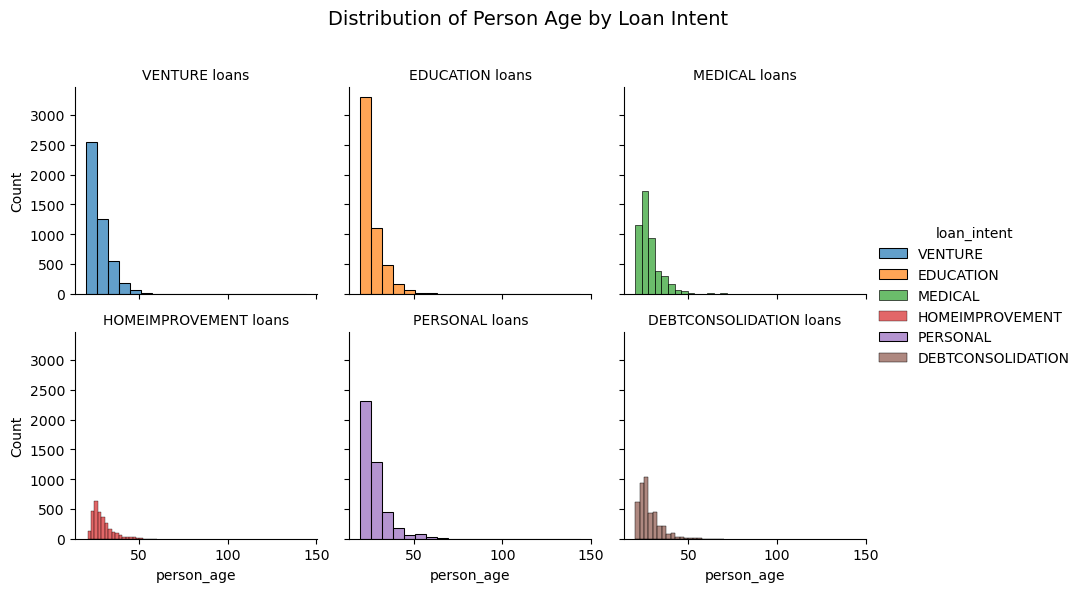

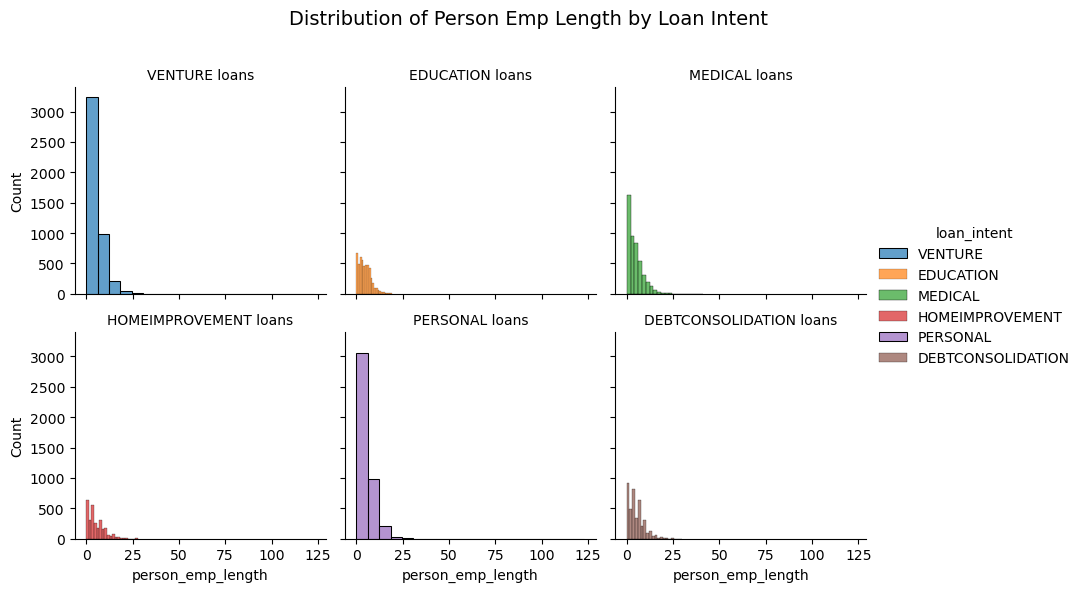

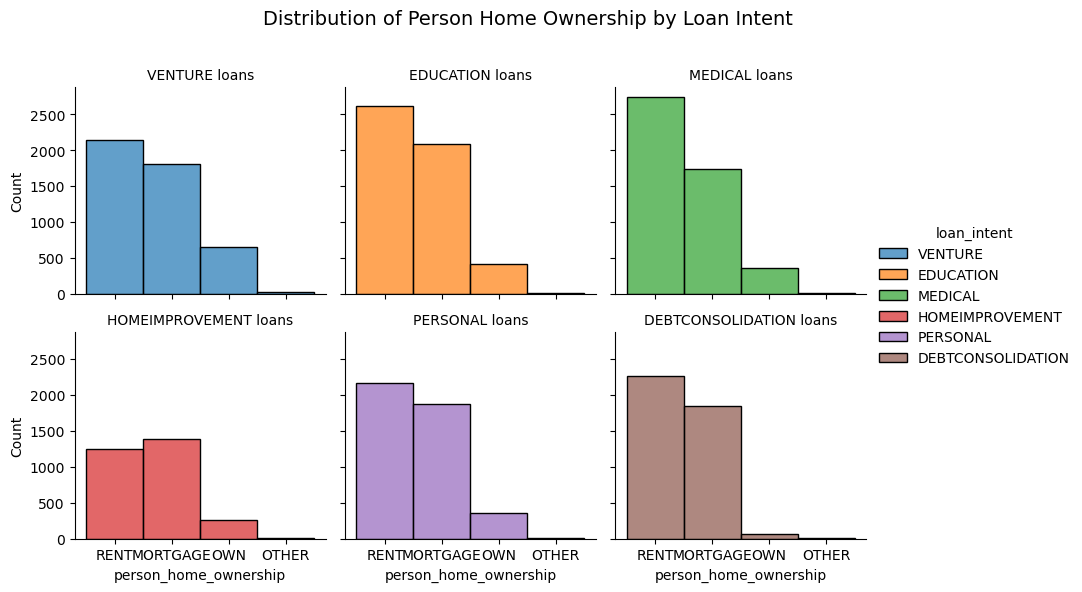

In [ ]:
features = ["person_age", "person_emp_length", "person_home_ownership"]


for feature in features:
    g = sns.FacetGrid(data=for_viz, col="loan_intent", hue="loan_intent", col_wrap=3)
    g.map(sns.histplot, feature, bins=20, alpha=0.7)
    g.set_titles(col_template="{col_name} loans")
    g.figure.subplots_adjust(top=0.85)
    g.figure.suptitle(f"Distribution of {feature.replace('_', ' ').title()} by Loan Intent", fontsize=14)
    g.add_legend()
    plt.show()

## Figure 1:

*First, we want to understand how loan intent varies with different features, specifically borrower age, length of employment, and homeownership status. Not only with this offer us qualitative insights, but also help us understand the distribution of borrowers we are encountering, and what patterns may emerge in the data.*

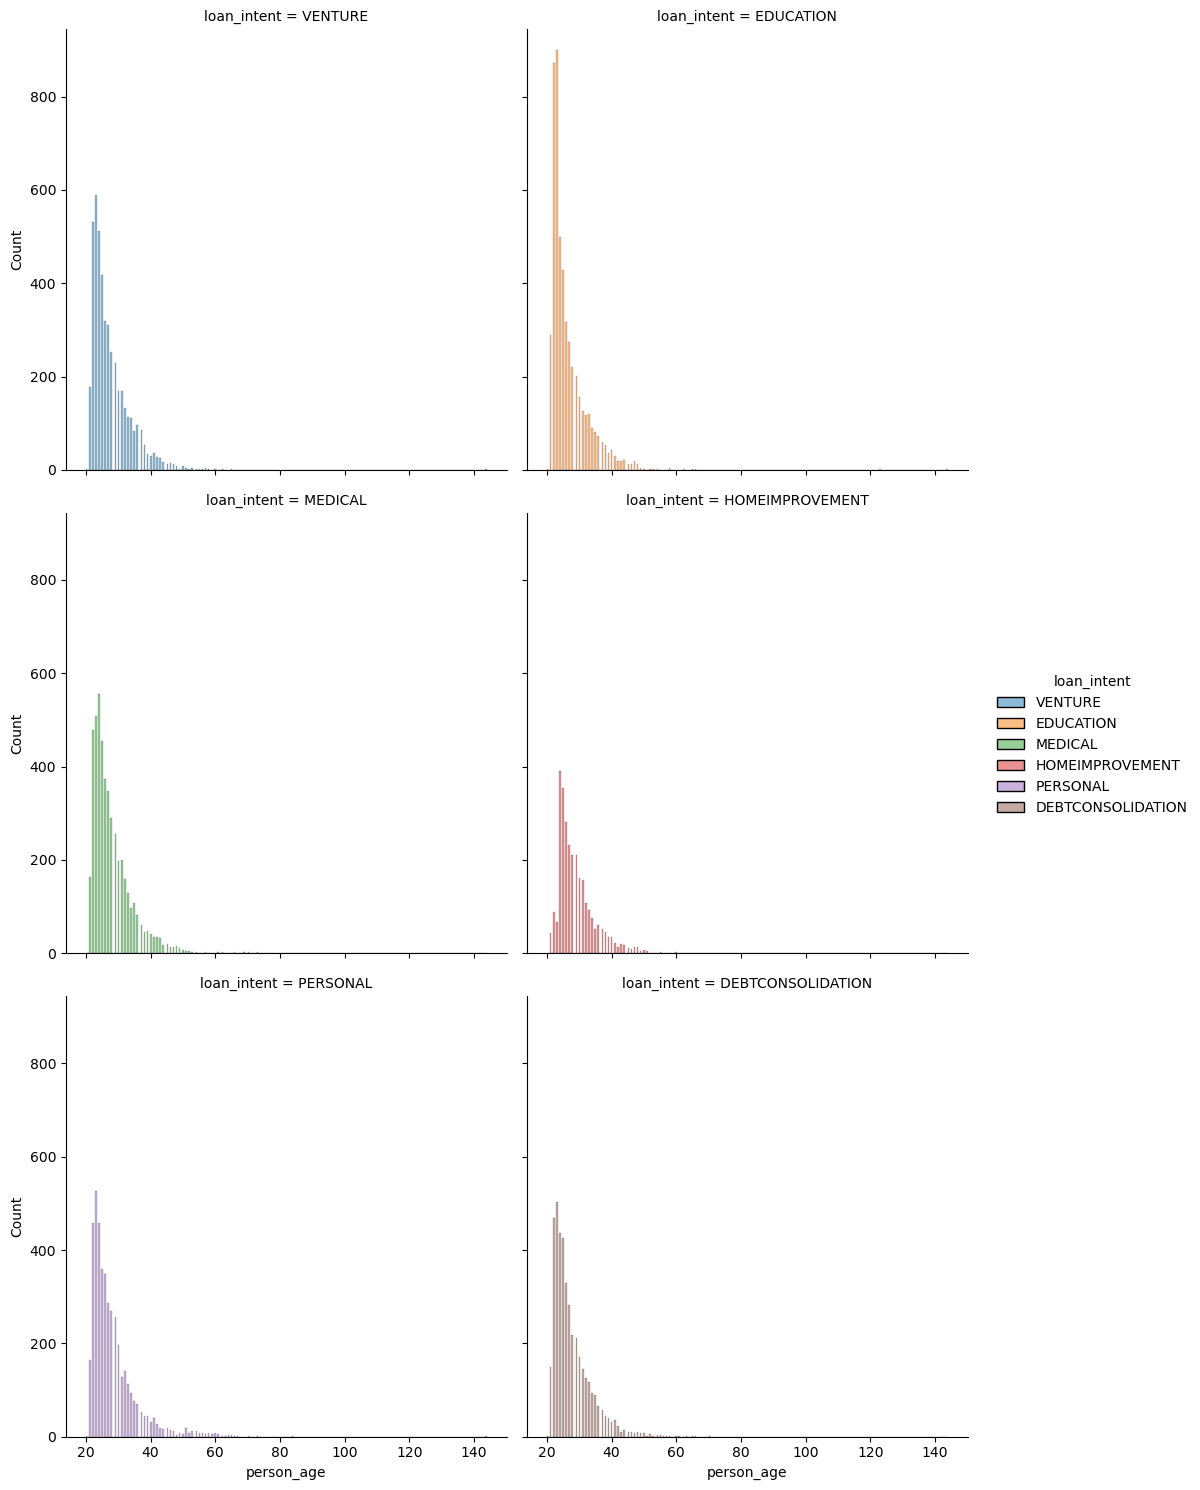

In [ ]:
sns.displot(data = for_viz, x = "person_age", col = "loan_intent", kind = "hist", hue = "loan_intent", col_wrap = 2)

### Discussion:

We are dealing with, for the most part, younger borrowers. The vast majority of borrowers across intents are 40 or younger, and above 40 years of age we see a steep drop off in borrowers. We see an especially high number of young borrowers in the data set seeking a loan for education. 

## Figure 2:

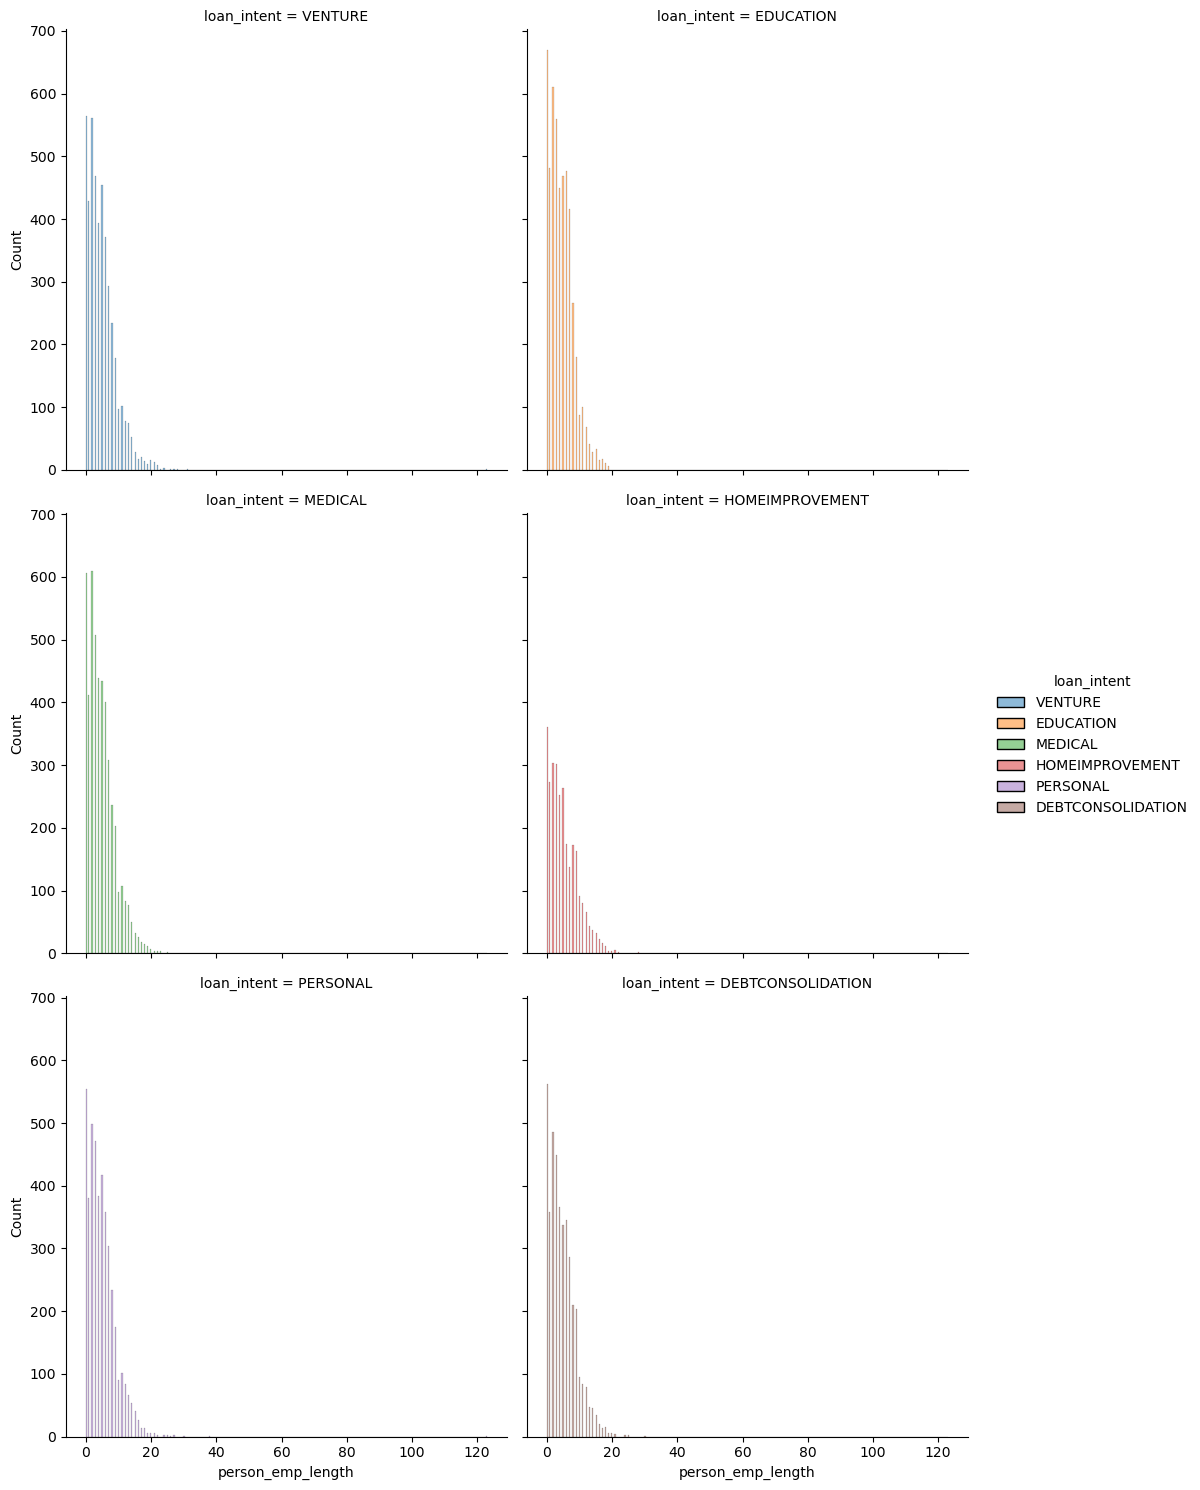

In [ ]:
sns.displot(data = for_viz, x = "person_emp_length", col = "loan_intent", kind = "hist", hue = "loan_intent", col_wrap = 2)

### Discussion:

We see similar shapes in these visualizations as in that comparing borrower age and loan intent, but the context of course gives it a different meaning. Across the board, we see that the majority of borrowers have been employed for under 20 years. Again, the highest count of borrowers is found in the subset of those seeking education loans. After 20 years of employment, loan seekers effectively disappear from view. The lowest number of loan seekers are found for home improvement loans.

## Figure 3:

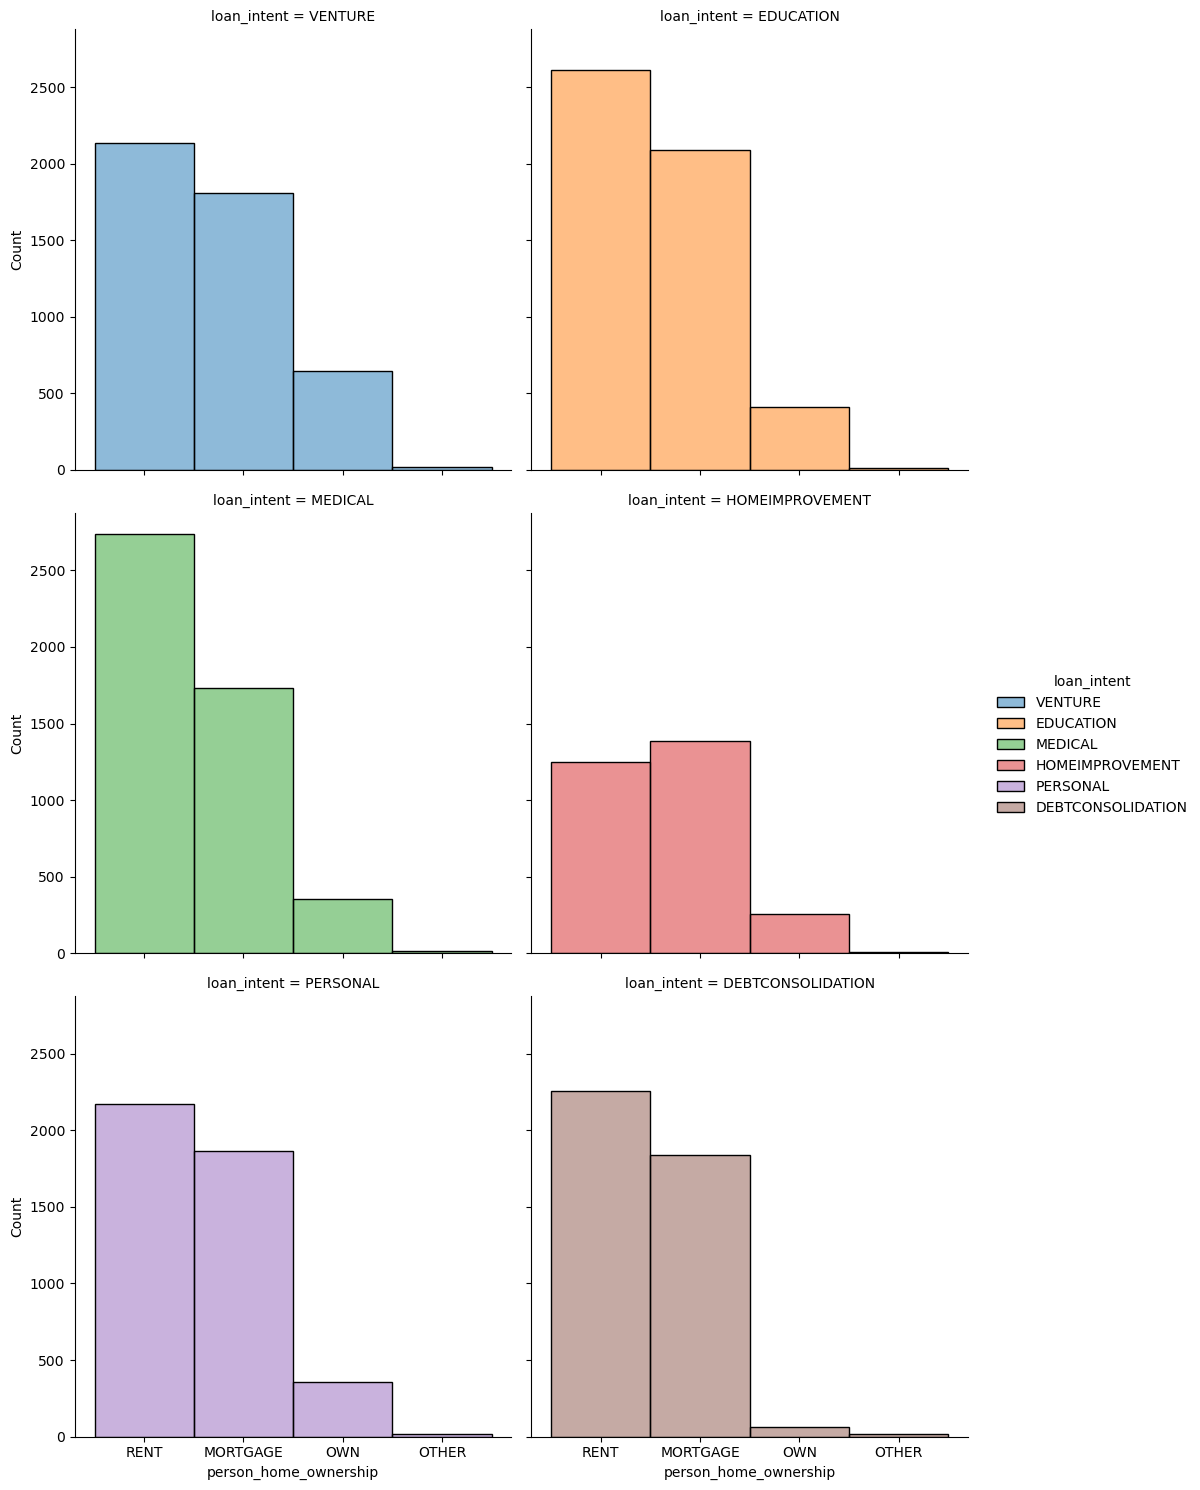

In [ ]:
sns.displot(data = for_viz, x = "person_home_ownership", col = "loan_intent", kind = "hist", hue = "loan_intent", col_wrap = 2)

### Discussion:

In nearly all of the visualizations, the highest number of borrowers seeking a loan are also renters. From highest to lowest counts, the borrowers' home ownership status is RENT, MORTGAGE, and OWN. This makes sense intuitively as home ownership is likely a proxy for financial secure individuals who may be less likely to seek a loan as a form of financial support. The only place we do not see this trend is in the Home Improvement visualization. Here, the plurality of borrowers are mortgaging their home. This also makes sense, however, because those who have mortgages are likely "newer" homeowners who are undergoing more renovations/home improvements than those who have owned a home for a long time.

## Figure 4:

*Next, I want to see the relationship between loan interest rates and loans as a percent of a borrowers income, and how this relationship may shape loan status - i.e. whether a borrower repays or defaults. Additionally, it will be helpful to compare visualization methods to see which Seaborn plots are more effective for such a large dataset*

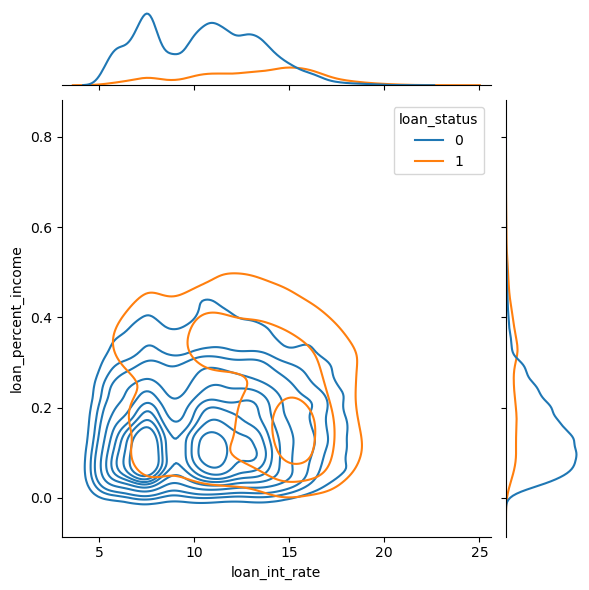

In [ ]:
sns.jointplot(for_viz, x = "loan_int_rate", y = "loan_percent_income", hue = "loan_status", kind = "kde", height=6)

<Axes: xlabel='loan_int_rate', ylabel='loan_percent_income'>

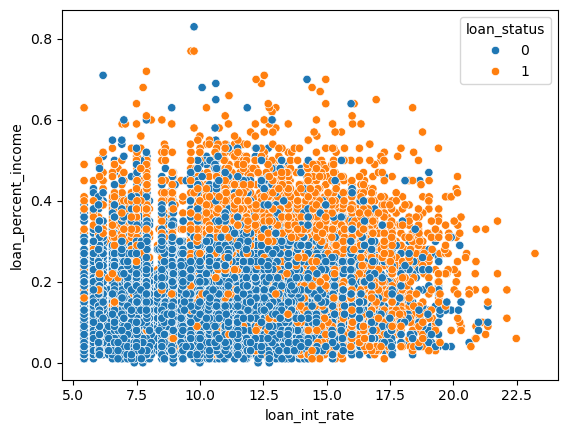

In [ ]:
sns.scatterplot(data = for_viz, x = "loan_int_rate", y = "loan_percent_income", hue = "loan_status")

### Discussion:

As seen above, using a scatterplot to visualize such a large set of data points is not a very effective approach. There is a great deal of overlap across our points, meaning that classification trends may be getting lost behind other data points. When looking at the joint plot, we first note from the edge plots that there are far more repaying than defaulting borrowers in our data set. Additionally, a higher distribution of borrowers repay loans they have a low interest rate, and their loan is a lower percent of their income. However, the reality remains that - based on the inner JointGrid - that there is still a great deal of overlap between borrowers of both loan status in relation to these two variables. Feature selection could not be done here purely through visualization.

## Part 2: Building a Model

In [ ]:
# First, establish the target column. This won't change so I initialize it here.
TARGET_COL = "loan_status"

# Even before processing the data, we perform some preliminary changes to the DataFrame to ensure
# future processing does not interfere with indexing, such as dropping entries with empty values,
# and converting qualitative features to one-hot encoded dummies
df_train = pd.get_dummies(df_train)
df_train = df_train.dropna()

In [ ]:
# Create a preprocessing function that will scale data and 
# create an X_train and y_train based on chosen feature columns
from sklearn.preprocessing import StandardScaler, MinMaxScaler

def preprocess(df, quant_cols, qual_cols, target_col):

    df_new = pd.DataFrame()
    df_new[quant_cols] = df[quant_cols]
    df_new[qual_cols] = df[qual_cols]
    df_new_target = df[target_col]

    scaler = StandardScaler()
    
    df_new[quant_cols] = scaler.fit_transform(df_new[quant_cols])
    df_new[qual_cols] = df_new[qual_cols]
    
    return df_new, df_new_target


### Experiment with features/models

In [ ]:
# Model imports
from sklearn.linear_model import LogisticRegression


In [ ]:
# First, I will test a model on all quantitative/qualitative features in the dataset

X1_quant_cols = ["person_age", 
                    "person_income", 
                    "person_emp_length",
                    "loan_int_rate", 
                    "loan_amnt", 
                    "loan_percent_income",
                    "cb_person_default_on_file_N",
                    "cb_person_default_on_file_Y",
                    "cb_person_cred_hist_length"]

X1_qual_cols = ["person_home_ownership_MORTGAGE",
                    "person_home_ownership_RENT",
                    "person_home_ownership_OWN",
                    "loan_intent_VENTURE",
                    "loan_intent_EDUCATION",
                    "loan_intent_MEDICAL",
                    "loan_intent_HOMEIMPROVEMENT",
                    "loan_intent_PERSONAL",
                    "loan_intent_DEBTCONSOLIDATION", ]


X1_train, y_train = preprocess(df_train, X1_quant_cols, X1_qual_cols, TARGET_COL)

LR1 = LogisticRegression()
fit1 = LR1.fit(X1_train, y_train)
LR1.score(X1_train, y_train)


0.8498712184048544

In [ ]:
# Having fit and scored a model on all feature columns, we now explore smaller feature combinations,
# looking to see if any particular combination maximizes classification accuracy
X2_quant_cols = ["loan_int_rate",  
                    "loan_percent_income",
                    "person_emp_length"]

X2_qual_cols = ["person_home_ownership_MORTGAGE",
                    "person_home_ownership_RENT",
                    "person_home_ownership_OWN"]

X2_train, y_train = preprocess(df_train, X2_quant_cols, X2_qual_cols, TARGET_COL)

LR2 = LogisticRegression()
fit2 = LR2.fit(X2_train, y_train)
LR2.score(X2_train, y_train)

0.8468153839437726

In [ ]:
# Similar to above block but for alternative feature combination

X3_quant_cols = ["loan_int_rate",  
                    "loan_percent_income",
                    "loan_amnt"]

X3_qual_cols = ["person_home_ownership_MORTGAGE",
                    "person_home_ownership_RENT",
                    "person_home_ownership_OWN"]

X3_train, y_train = preprocess(df_train, X3_quant_cols, X3_qual_cols, TARGET_COL)

LR3 = LogisticRegression()
fit3 = LR3.fit(X3_train, y_train)
LR3.score(X3_train, y_train)

0.844632645043

In [ ]:
# Now that we have fit a Logistic Regression model on our data, we have access to the
# Model weights via the .coef_ attribute.
# However, we to transform this array into a column because otherwise it is just a row,
# complicating necessary computations in the future
print(fit1.coef_.T)

[[-0.0423979 ]
 [ 0.04612073]
 [-0.02431996]
 [ 1.03609245]
 [-0.57955282]
 [ 1.3239725 ]
 [-0.0143236 ]
 [ 0.0143236 ]
 [-0.00851694]
 [-0.27565869]
 [ 0.46232549]
 [-1.75917877]
 [-0.87364387]
 [-0.6441703 ]
 [-0.02154856]
 [ 0.24354326]
 [-0.46649075]
 [ 0.15978062]]


## Part 3: Find a Threshold

In [ ]:
# Define a function that calculates the linear scores of our model
# By calculating the cross product between our predictors and model weights
def linear_score(X, w):
    return X@w.T

X1_scores = linear_score(X1_train, fit1.coef_)
X1_scores = X1_scores.iloc[:, 0] # All rows and first column to convert to Series

X2_scores = linear_score(X2_train, fit2.coef_)
X2_scores = X2_scores.iloc[:, 0] # All rows and first column to convert to Series

X3_scores = linear_score(X3_train, fit3.coef_)
X3_scores = X3_scores.iloc[:, 0] # All rows and first column to convert to Series


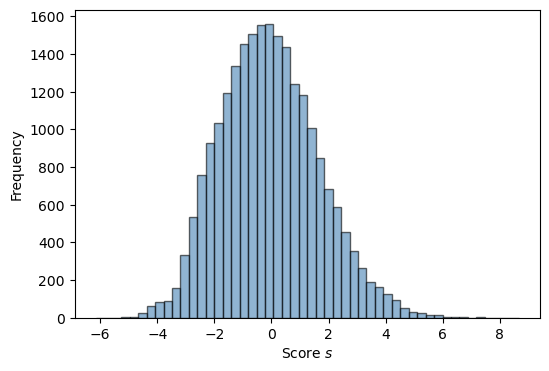

In [ ]:
# Plot the scores of our linear score function to see score distribution
from matplotlib import pyplot as plt
fig, ax = plt.subplots(1, 1, figsize = (6, 4))
hist = ax.hist(X3_scores, bins = 50, color = "steelblue", alpha = 0.6, linewidth = 1, edgecolor = "black")
labs = ax.set(xlabel = r"Score $s$", ylabel = "Frequency") 

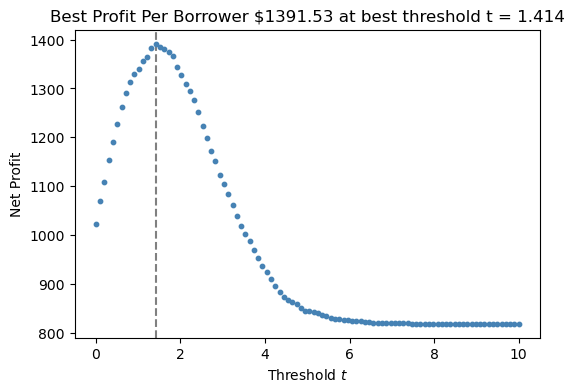

In [ ]:
# Now that we know our score distributions, we can select a range of possible thresholds
# and define a function to identify the threshold which maximizes profit
def calculate_repaid_profit(df):
    return (df["loan_amnt"] * ((1 + 0.25 * (df["loan_int_rate"]) / 100) ** 10) - df["loan_amnt"])

def calculate_default_profit(df):
    return (df["loan_amnt"] * ((1 + 0.25 * (df["loan_int_rate"] / 100)) ** 3) - (1.7 * df["loan_amnt"]))

def plot_best_threshold(df, scores, y_train):
    best_profit = -1000000000
    best_threshold = 0

    fig, ax = plt.subplots(1, 1, figsize = (6, 4)) 
    for t in np.linspace(0, 10, 100):
        y_pred = scores > t
        tp = (y_pred == 0) & (y_train == 0)
        # tp.sum()
        fp = (y_pred == 0) & (y_train == 1)
        # fp.sum()
        profit = calculate_repaid_profit(df[tp]).sum() + calculate_default_profit(df[fp]).sum()
        profit /= len(df)
        ax.scatter(t, profit, color = "steelblue", s = 10)
        if profit > best_profit: 
            best_profit = profit
            best_threshold = t


    ax.axvline(best_threshold, linestyle = "--", color = "grey", zorder = -10)
    labs = ax.set(xlabel = r"Threshold $t$", ylabel = "Net Profit", title = f"Best Profit Per Borrower ${best_profit:.2f} at best threshold t = {best_threshold:.3f}")

plot_best_threshold(df_train, X3_scores, y_train)

## Evaluate My Model from the Bank's Perspective

Optimal Profit is $1102.18


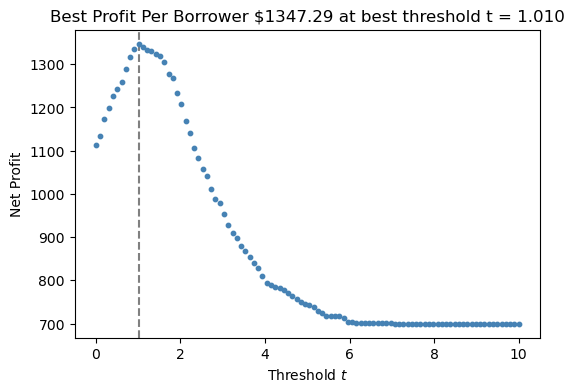

In [ ]:
OPTIMAL_THRESHOLD = 1.414

url = "https://raw.githubusercontent.com/PhilChodrow/ml-notes/main/data/credit-risk/test.csv"
df_test = pd.read_csv(url)
df_test = pd.get_dummies(df_test)
df_test = df_test.dropna()
X_test, y_test = preprocess(df_test, X1_quant_cols, X1_qual_cols, TARGET_COL)

test_scores = linear_score(X_test, fit1.coef_)
test_scores = test_scores.iloc[:, 0]

y_pred = test_scores > OPTIMAL_THRESHOLD
test_tp = (y_pred == 0) & (y_test == 0)
test_tn = (y_pred == 1) & (y_test == 1)
test_profit = calculate_repaid_profit(df_test[test_tp]).sum() + calculate_default_profit(df_test[test_tn]).sum()
test_profit /= len(df_test)
print(f"Optimal Profit is ${test_profit:.2f}")
plot_best_threshold(df_test, test_scores, y_test)

In [ ]:
df_test["risk_score"] = test_scores
age_risk_score = df_test.groupby("person_age")[["person_age", "risk_score"]].mean()

 Average age of approved borrower: 27.87536718422157 vs. Average age of denied borrower: 26.935751295336786


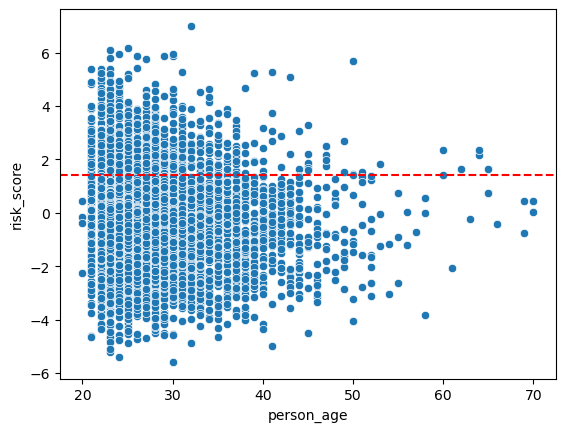

In [ ]:
sns.scatterplot(df_test, x = "person_age", y = "risk_score")
plt.axhline(y=OPTIMAL_THRESHOLD, color='red', linestyle='--')
approved = df_test[df_test["risk_score"] < OPTIMAL_THRESHOLD]
avg_age_approved = approved["person_age"].mean()
denied = df_test[df_test["risk_score"] > OPTIMAL_THRESHOLD]
avg_age_denied = denied["person_age"].mean()
print(f" Average age of approved borrower: {avg_age_approved} vs. Average age of denied borrower: {avg_age_denied}")


### Analysis:

On average, the data indicates that the average age of borrowers approved with our threshold is less than 1 year older than the average age of denied borrowers. As such, it appears that the people of varying age groups have a similar degree of access to credit under my proposed system.

In [ ]:
count_medical_total =  df_test[df_test["loan_intent_MEDICAL"]]
count_medical_approved = df_test[df_test["loan_intent_MEDICAL"] & (df_test["risk_score"] < OPTIMAL_THRESHOLD)]
count_medical_default = df_test[df_test["loan_intent_MEDICAL"] & (df_test["risk_score"] < OPTIMAL_THRESHOLD) & (df_test["loan_status"])]

print(f"Percentage of medical seeking borrowers which were approved: {(len(count_medical_approved)/len(count_medical_total))*100:.2f}%")
print(f"Percentage of approved medical seeking borrowers who defaulted: {(len(count_medical_default)/len(count_medical_approved))*100:.2f}%")



Percentage of medical seeking borrowers which were approved: 77.54%
Percentage of approved medical seeking borrowers who defaulted: 15.02%


In [ ]:
count_venture_total =  df_test[df_test["loan_intent_VENTURE"]]
count_venture_approved = df_test[df_test["loan_intent_VENTURE"] & (df_test["risk_score"] < OPTIMAL_THRESHOLD)]
count_venture_default = df_test[df_test["loan_intent_VENTURE"] & (df_test["risk_score"] < OPTIMAL_THRESHOLD) & (df_test["loan_status"])]
print(f"Percentage of venture seeking borrowers which were approved: {(len(count_venture_approved)/len(count_venture_total))*100:.2f}%")
print(f"Percentage of approved venture seeking borrowers who defaulted: {(len(count_venture_default)/len(count_venture_approved))*100:.2f}%")

Percentage of medical seeking borrowers which were approved: 89.94%
Percentage of approved medical seeking borrowers who defaulted: 7.50%


In [ ]:
count_education_total =  df_test[df_test["loan_intent_EDUCATION"]]
count_education_approved = df_test[df_test["loan_intent_EDUCATION"] & (df_test["risk_score"] < OPTIMAL_THRESHOLD)]
count_education_default = df_test[df_test["loan_intent_EDUCATION"] & (df_test["risk_score"] < OPTIMAL_THRESHOLD) & (df_test["loan_status"])]
print(f"Percentage of education seeking borrowers which were approved: {(len(count_education_approved)/len(count_education_total))*100:.2f}%")
print(f"Percentage of approved education seeking borrowers who defaulted: {(len(count_education_default)/len(count_education_approved))*100:.2f}%")

Percentage of medical seeking borrowers which were approved: 88.78%
Percentage of approved medical seeking borrowers who defaulted: 10.73%


### Analysis:

Based on the above data, borrowers seeking a loan for medical reasons have a more difficult time accessing credit under my proposed system. Only 77.54% of borrowers from the test set who were seeking medical loans were approved compared to venture at 89.94% and education borrowers at 88.78%. However, at the same time, the rate of default was higher amongst medical borrowers - 15.02% - compared to venture - 7.50% - and education - 10.73%.

 Average income of approved borrower: 71671.01657574486 vs. Average income of denied borrower: 41555.21658031088


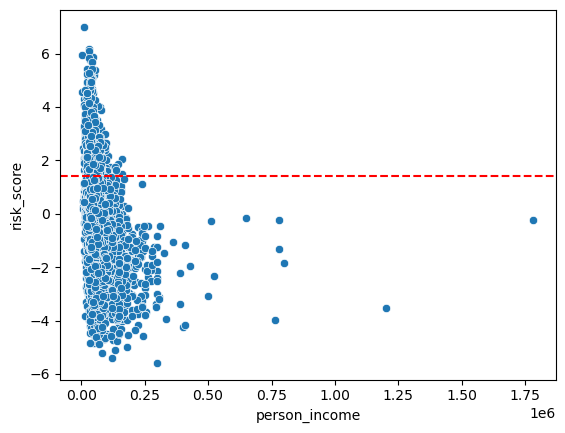

In [ ]:
sns.scatterplot(df_test, x = "person_income", y = "risk_score")
plt.axhline(y=OPTIMAL_THRESHOLD, color='red', linestyle='--')
approved = df_test[df_test["risk_score"] < OPTIMAL_THRESHOLD]
avg_income_approved = approved["person_income"].mean()
denied = df_test[df_test["risk_score"] > OPTIMAL_THRESHOLD]
avg_income_denied = denied["person_income"].mean()
print(f" Average income of approved borrower: {avg_income_approved} vs. Average income of denied borrower: {avg_income_denied}")


### Analysis:

On average, the data indicates that the income of borrowers approved with our threshold is notably higher - ~$30,000 higher - than the income of denied borrowers. As such, it appears that the people of lower income groups may have a more difficult time accessing credit under this system.

## Concluding Remarks

In conclusion, this post examined decision theory in classification through both quantitative and ethical lenses, aiming to optimize a bank's expected profit per borrower. The analysis began with visual exploration of the data, followed by fitting logistic regression models using various feature combinations. By computing linear risk scores, an initial optimal threshold of 1.414 was identified — yielding $1391.53 per borrower on the training data and $1102.18 on the test data. However, further analysis of the test set revealed an optimal threshold of 1.010, which maximized profit at $1347.19 per borrower, indicating that while the system maintained high profitability, it did not capture the test data’s full profit potential.

At the end of the study, I explored the fairness of this model. Fairness in general is a difficult concept to define, but is complicated to a high degree in the context of machine learning models which make predictions about people. A machine learning model can never achieve full fairness - making a decision about an outcome *only after* considering not only all features/traits of a person relevant to that outcome, but also the context-specificity of those features - as ML is fundamentally built on generalization from examples. So, instead the question of fairness in this post should not be understood as an absolute, but relative to the context at hand: is the model *fair enough*? Also, the notion of fairness depends on the position of the evaluator - what fairness means to me fundamentally as a person is different to someone whose primary goal is to develop a system which maximizes profits, and therefore makes decisions about borrowers with historical default rates in mind.

After analyzing the outcome data, I noticed that the percent of approved borrowers seeking a medical loan was over 10% lower than that of education/venture seeking borrowers. However, at the same time, medical borrowers had a default rate which was 5% higher than the other two loan seeking groups. From this, I am inclined to ask whether, considering their higher rate of default, it is fair for medical borrowers to have a harder time accessing credit? On one hand, I want to say this is not fair, as even though the borrowers have a history of higher defaults, the value/importance of a medical loan - to potentially save ones life - is much higher than that of an education or venture loan seeker. But at the same time, I wonder whether a bank-loaning model is realistically possible or responsible to include this value in an automated decision making model: can a profit maximizing model actually objectively quantify the ethical/lived importance of a loan to a borrower? Ultimately, these observations highlight the inherent tension between profit optimization and equitable access to credit. While the model accurately identifies risk patterns based on historical data, it falls short in capturing broader social values, particularly for medical needs where the stakes may be much higher. This raises critical ethical questions: should decision systems rely solely on past performance, or must they also adjust to recognize the importance of timely, life-saving credit?